Main hypothesis: Banks (morgages) fuel house price increase

Exploring: the feedback loop between credit expansion, inequality, and housing prices with an emphasis on whether rising mortgage volumes reflect not just inflation but changing financial behavior and structural inequality

Over time, loans have increased, not only due to inflation?
1. Idea: Banks are doing bigger risks because they can just own the property after the borrower defaults -> taking away resources -> bigger battle for resources -> price increase -> loans increase because wages didn’t increase
-> Formulate a relationship between morgages, inequality and housing price

Key Variables:

- Housing Prices
- Mortgage Credit
- Interes Rates
- Wages/Income
- Inequality
- Inflation
- Housing Supply


Real House Price = nominal house price / CPI
Real Mortgage Credit = mortgage credit / CPI
Mortgage-to-Income Ratio = total mortgage credit / disposable personal income
Debt-Service Ratio = mortgage payments / income
Housing Affordability Index = function of income, rates, and home prices

In [58]:
import pandas as pd
from pathlib import Path

data_path = Path("data")

# Read the 'Monthly' sheet from the median_house_price file
prices = pd.read_excel(data_path / "median_house_price.xlsx", sheet_name="Monthly")
# Ensure the date column is datetime
if not pd.api.types.is_datetime64_any_dtype(prices["observation_date"]):
    prices["observation_date"] = pd.to_datetime(prices["observation_date"])

prices.set_axis(prices["observation_date"])  # index by date
# Read CPI file and parse dates; adjust column name if different
cpi_data = pd.read_excel(
    data_path / "cpi.xlsx",
    sheet_name="Monthly",
    parse_dates=["observation_date"]  # ensure this is the actual date column name
)

# Ensure the date column is datetime
if not pd.api.types.is_datetime64_any_dtype(cpi_data["observation_date"]):
    cpi_data["observation_date"] = pd.to_datetime(cpi_data["observation_date"])

# Filter CPI data to start from 1963-01-01 (inclusive)
cpi_data = cpi_data[cpi_data["observation_date"] >= "1963-01-01"]

# Extract CPI series (column named 'cpi' in the Excel file)
cpi = cpi_data["cpi"]

# Optional: reset index or keep dates as index
cpi = cpi.set_axis(cpi_data["observation_date"])  # index by date if desired

# Quick check
print(cpi.head())
print(f"Rows after filtering: {len(cpi)}")

observation_date
1963-01-01    30.44
1963-02-01    30.48
1963-03-01    30.51
1963-04-01    30.48
1963-05-01    30.51
Name: cpi, dtype: float64
Rows after filtering: 752


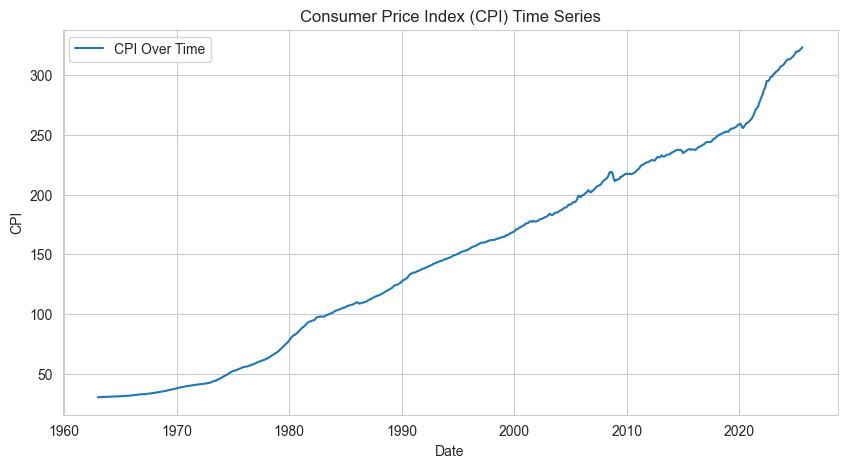

In [59]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(cpi.index, cpi.values, label='CPI Over Time')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('Consumer Price Index (CPI) Time Series')
plt.legend()
plt.show()



<Figure size 640x480 with 0 Axes>

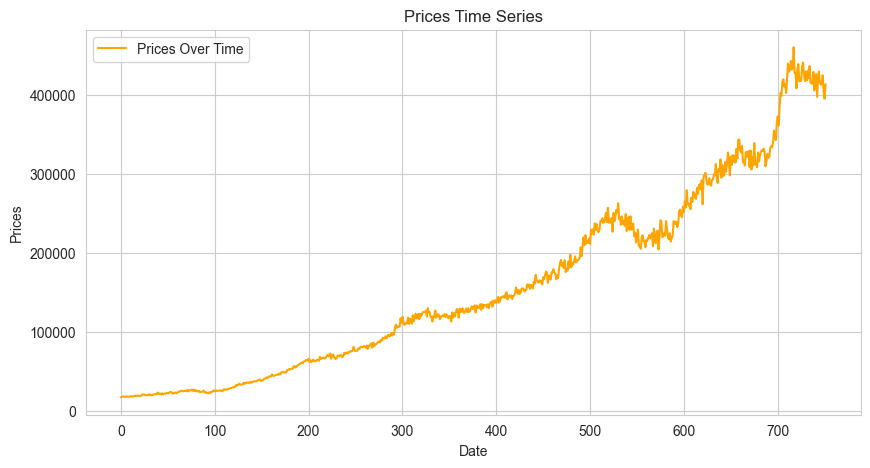

In [60]:
# clear last plot
plt.clf()
# plot nominal prices
plt.figure(figsize=(10, 5))
plt.plot(prices.index, prices.price, label='Prices Over Time', color='orange')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.title('Prices Time Series')
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

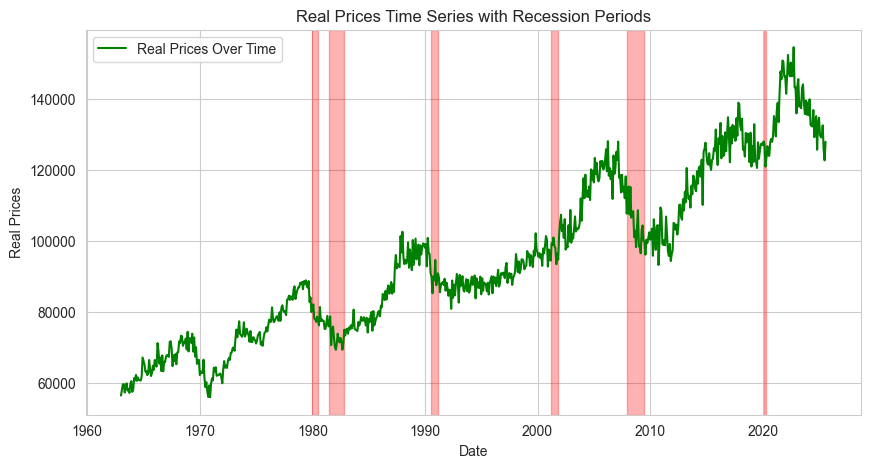

In [61]:

cpi_100 = cpi / 100

real_prices = prices.price.values / cpi_100.values  # Align CPI to prices index

# plot recession periods
plt.clf()
plt.figure(figsize=(10, 5))
plt.plot(prices.observation_date, real_prices, label='Real Prices Over Time',color='green')
# Highlight recession periods
recession_periods = [
    ("1980-01-01", "1980-07-01"),  # Early 1980s recession
    ("1981-07-01", "1982-11-01"),  # Double-dip recession
    ("1990-07-01", "1991-03-01"),  # Early 1990s recession
    ("2001-03-01", "2001-11-01"),  # Dot-com recession
    ("2007-12-01", "2009-06-01"),  # Great Recession
    ("2020-02-01", "2020-04-01")   # COVID-19 recession
]
for start, end in recession_periods:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='red', alpha=0.3) # Highlight recession periods
plt.xlabel('Date')
plt.ylabel('Real Prices')
plt.title('Real Prices Time Series with Recession Periods')
plt.legend()
plt.show()  

In [62]:
# log transform
import numpy as np
log_real_prices = np.log(real_prices)
# INDEX BY OBSERVATION DATE
log_real_prices = pd.Series(log_real_prices, index=prices.observation_date)

ADF Statistic: -1.4670607428141176
p-value: 0.5497384698110896
Critical Value (1%): -3.439
Critical Value (5%): -2.866
Critical Value (10%): -2.569
ADF Statistic (differenced): -5.586640585840968
p-value (differenced): 1.358237299554451e-06
Critical Value (1%): -3.439
Critical Value (5%): -2.866
Critical Value (10%): -2.569


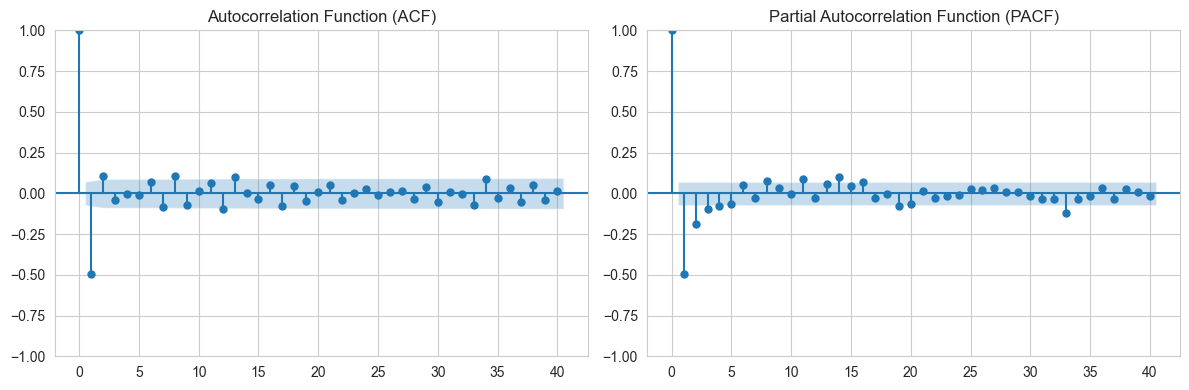

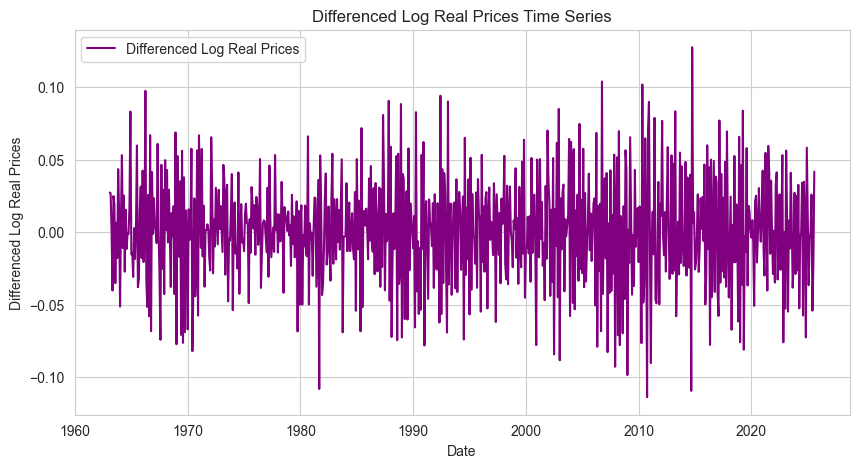

In [63]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# check stationarity with ADF test
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(log_real_prices)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
for key, value in adf_result[4].items():
    print('Critical Value (%s): %.3f' % (key, value))
    
# difference prices to make it stationary
log_real_prices_diff = pd.Series(log_real_prices).diff().dropna()
log_real_prices_diff.index = log_real_prices.index[1:]  # Adjust index after differencing
adf_result_diff = adfuller(log_real_prices_diff)
print('ADF Statistic (differenced):', adf_result_diff[0])
print('p-value (differenced):', adf_result_diff[1])
for key, value in adf_result_diff[4].items():
    print('Critical Value (%s): %.3f' % (key, value))
    
    # Basic ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(log_real_prices_diff, lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(log_real_prices_diff, lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()
    
# plot the differenced series
plt.figure(figsize=(10, 5))
plt.plot(log_real_prices_diff.index, log_real_prices_diff.values, label='Differenced Log Real Prices', color='purple')
plt.xlabel('Date')
plt.ylabel('Differenced Log Real Prices')
plt.title('Differenced Log Real Prices Time Series')
plt.legend()
plt.show()

It's not stationary, so it needs to be differenced. After Differencing it becomes stationary

In [64]:
from sklearn.model_selection import train_test_split

# take only last 414 values
log_real_prices_diff = log_real_prices_diff[-414:]
real_prices = real_prices[-414:]
# reindex to ensure proper indexing
# log_real_prices_diff = log_real_prices_diff.reset_index(drop=True)
# split into train and test sets
y_train, y_test = train_test_split(log_real_prices_diff, test_size=0.2, shuffle=False)
y_train_original, y_test_original = train_test_split(real_prices, test_size=0.2, shuffle=False)

y_train.index = pd.DatetimeIndex(y_train.index.values,
                               freq=y_train.index.inferred_freq)
print(f"Training set length: {len(y_train)}")
print(f"Test set length: {len(y_test)}")


Training set length: 331
Test set length: 83


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  331
Model:                 ARIMA(3, 0, 0)   Log Likelihood                 652.934
Date:                Thu, 04 Dec 2025   AIC                          -1295.867
Time:                        18:52:22   BIC                          -1276.857
Sample:                    03-01-1991   HQIC                         -1288.285
                         - 09-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.277      0.202      -0.001       0.003
ar.L1         -0.6638      0.052    -12.767      0.000      -0.766      -0.562
ar.L2         -0.3016      0.057     -5.301      0.0

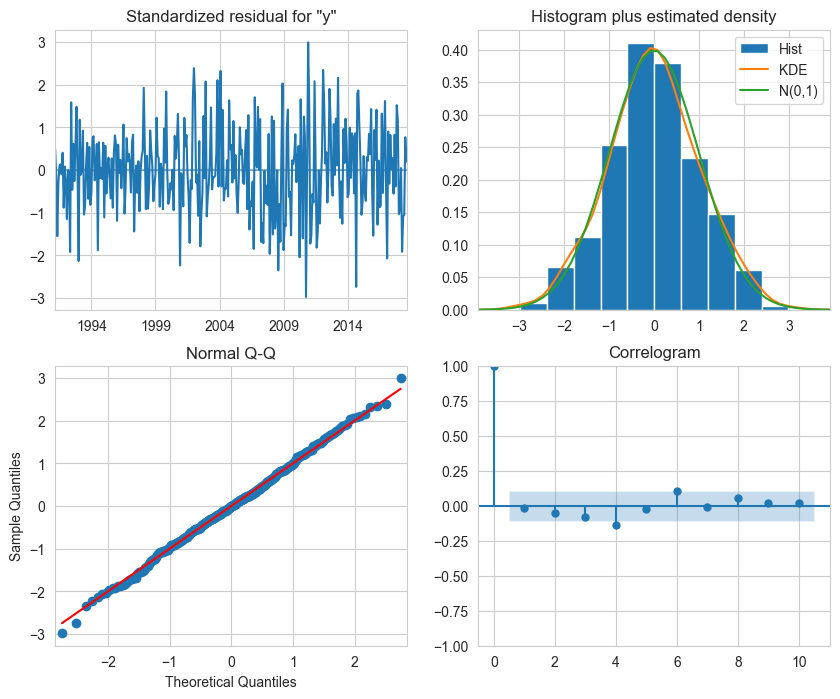

Training Set Performance:


NameError: name 'y_pred_train' is not defined

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# ARIMA(p, d, q) where:
# p = AR lags (2 in your case)
# d = differencing order (0 if your data is already stationary)
# q = MA terms (0 for no MA)



model = ARIMA(y_train, order=(3, 0, 0))
results = model.fit()

# View results
print(results.summary())
results.plot_diagnostics(figsize=(10,8))
plt.show()

# calculate rmse on test set
print("Training Set Performance:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.4f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train):.4f}")

AR roots: [-1.57188648-0.j         -0.0486625 -1.87573035j -0.0486625 +1.87573035j]
All AR roots outside unit circle? True


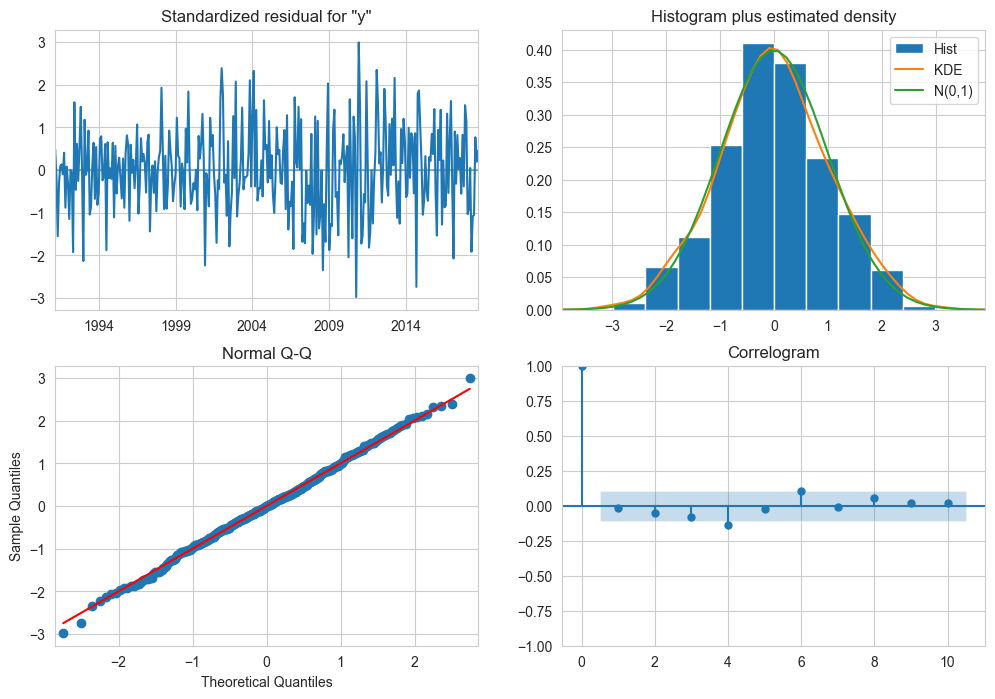

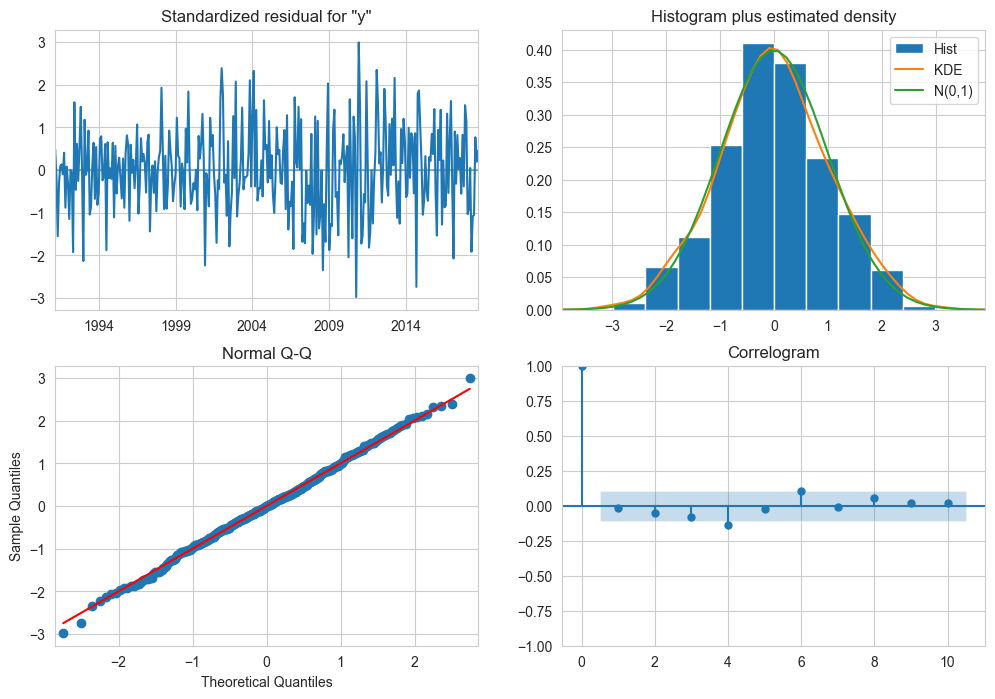

In [66]:
# Check AR roots
ar_roots = results.arroots
seasonal_roots = results.seasonalarroots if hasattr(results, 'seasonalarroots') else []

print("AR roots:", ar_roots)
print("All AR roots outside unit circle?", all(abs(r) > 1 for r in ar_roots))

if len(seasonal_roots) > 0:
    print("Seasonal roots:", seasonal_roots)
    print("All seasonal roots outside unit circle?", 
          all(abs(r) > 1 for r in seasonal_roots))

# Visualize
from statsmodels.graphics.tsaplots import plot_predict
results.plot_diagnostics(figsize=(12, 8))

In [67]:
import itertools
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

p = range(0, 10)


aic_table = []
bic_table = []
results = []

for i in p:
    try:
        model = ARIMA(y_train, order=(i,0,0))
        results = model.fit()
        aic_table.append((i,0,0, results.aic))
        bic_table.append((i,0,0, results.bic))
        results.append(results)
    except:
        continue

aic_df = pd.DataFrame(aic_table, columns=["p","d","q","AIC"])
bic_df = pd.DataFrame(bic_table, columns=["p","d","q","BIC"])
print(aic_df.sort_values("AIC").head())


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   p  d  q          AIC
5  5  0  0 -1305.175811
6  6  0  0 -1303.200629
7  7  0  0 -1301.390382
8  8  0  0 -1299.389356
4  4  0  0 -1297.669003


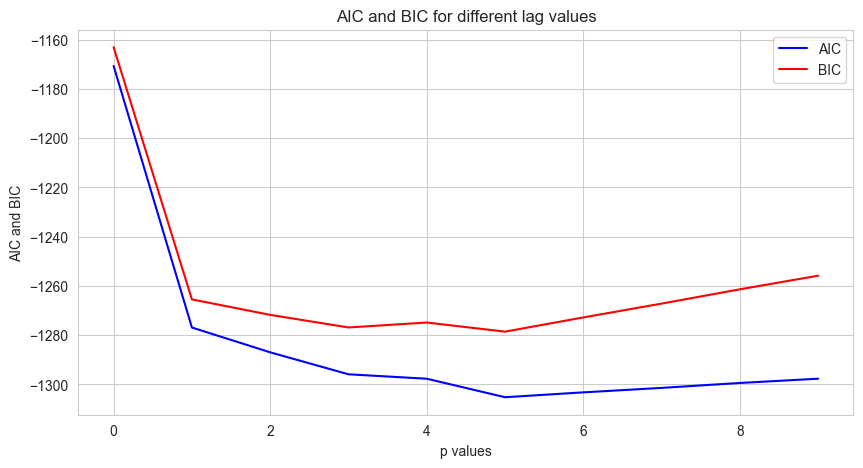

In [68]:
plt.figure(figsize=(10, 5))

for p_value in p:
    aic = aic_df[aic_df['d'] == p_value]
    bic = bic_df[bic_df['d'] == p_value]

    plt.plot(aic['p'], aic['AIC'], color='blue')
    plt.plot(bic['p'], bic['BIC'], color='red')

# Add legend using proxy artists
plt.plot([], [], color='blue', label='AIC')
plt.plot([], [], color='red', label='BIC')

plt.xlabel('p values')
plt.ylabel('AIC and BIC')
plt.title('AIC and BIC for different lag values')
plt.legend()
plt.show()


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  331
Model:                 ARIMA(3, 0, 0)   Log Likelihood                 652.934
Date:                Thu, 04 Dec 2025   AIC                          -1295.867
Time:                        18:50:19   BIC                          -1276.857
Sample:                    03-01-1991   HQIC                         -1288.285
                         - 09-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.277      0.202      -0.001       0.003
ar.L1         -0.6638      0.052    -12.767      0.000      -0.766      -0.562
ar.L2         -0.3016      0.057     -5.301      0.0

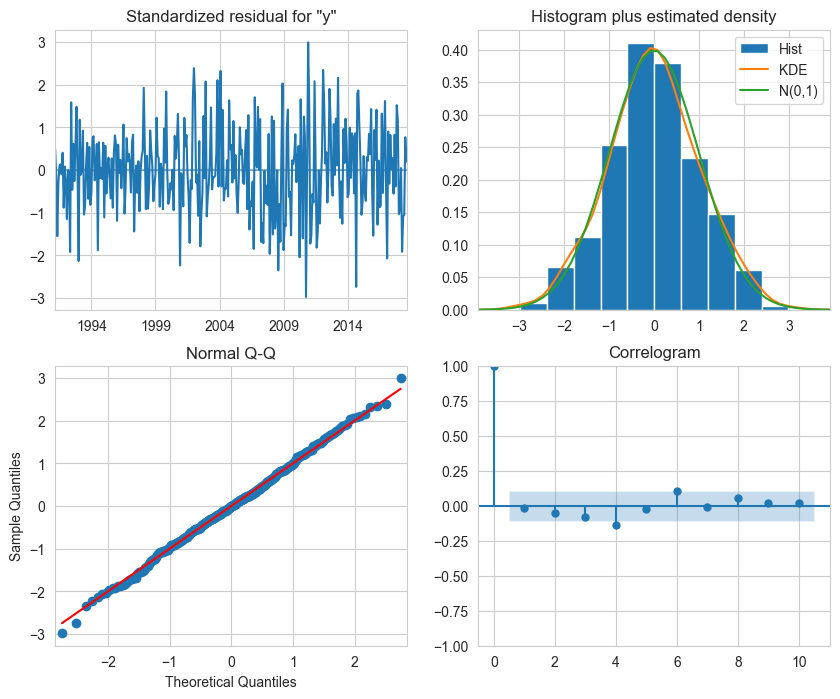

In [69]:
# fit an arima 3,0,0 model based on the aic and bic results
model = ARIMA(y_train, order=(3,0,0))
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(10,8))
plt.show()

Running AR(3) Forecasting Schemes...
Total observations: 414
Training size: 331
Test size: 83

Running Rolling Window Forecast...
Running Expanding Window Forecast...
Running One-Step Forecast...

AR(3) FORECASTING SCHEMES COMPARISON
          Scheme     RMSE      MAE       R²   MAPE (%)  N_predictions
  Rolling Window 0.031716 0.026296 0.264227 579.368989             83
Expanding Window 0.031180 0.025946 0.288897 591.351618             83
        One-Step 0.031094 0.025839 0.292827 585.804079             83


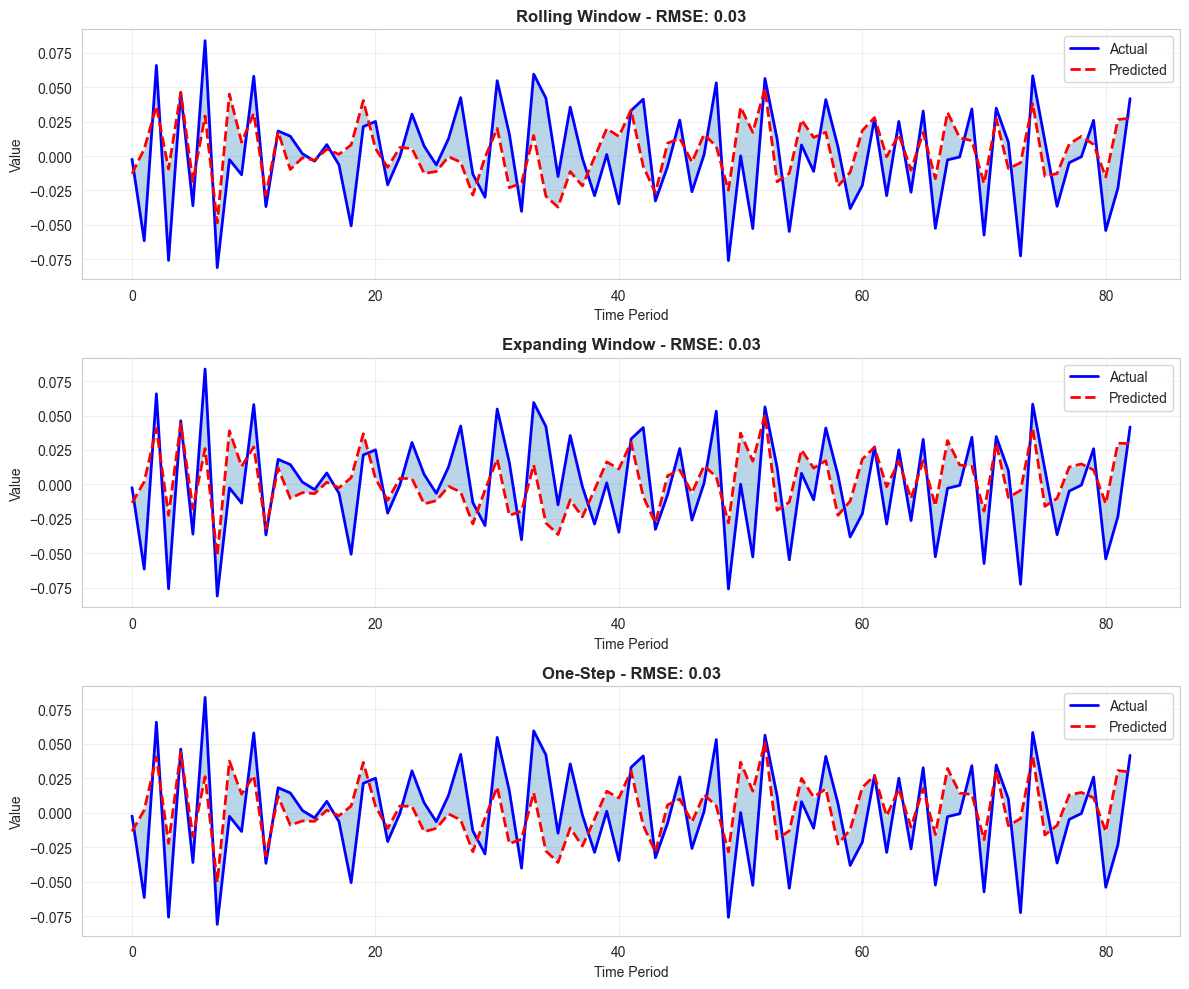

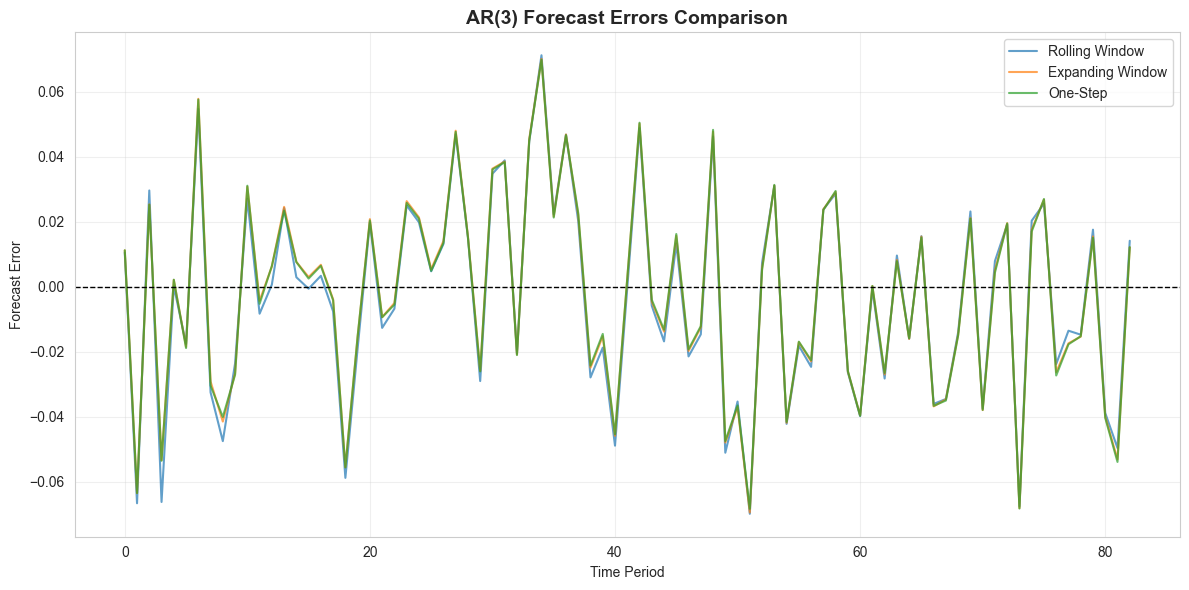


Visualizations saved as 'ar3_forecast_comparison.png' and 'ar3_forecast_errors.png'


In [70]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt


def create_ar3_features(y, lag=3):
    """
    Create lagged features for AR(3) model
    Returns X (lagged features) and y (target values)
    """
    n = len(y)
    X = np.zeros((n - lag, lag))
    y_target = np.zeros(n - lag)
    
    for i in range(lag, n):
        X[i - lag] = [y[i-1], y[i-2], y[i-3]]
        y_target[i - lag] = y[i]
    
    return X, y_target


def fit_ar3(y_train):
    """
    Fit AR(3) model using OLS
    Returns coefficients [phi1, phi2, phi3, intercept]
    """
    X, y_target = create_ar3_features(y_train, lag=3)
    
    # Add intercept
    X_with_intercept = np.column_stack([X, np.ones(len(X))])
    
    # OLS estimation: beta = (X'X)^(-1) X'y
    coeffs = np.linalg.lstsq(X_with_intercept, y_target, rcond=None)[0]
    
    return coeffs  # [phi1, phi2, phi3, intercept]


def predict_ar3(y_history, coeffs, steps=1):
    """
    Predict next value(s) using AR(3) model
    y_history: array of recent observations (at least last 3 values)
    coeffs: [phi1, phi2, phi3, intercept]
    steps: number of steps to forecast
    """
    y_history = np.array(y_history).flatten()
    predictions = []
    
    # Make a copy to avoid modifying original
    history = list(y_history[-3:])  # Keep last 3 values
    
    for _ in range(steps):
        # AR(3): y_t = phi1*y_{t-1} + phi2*y_{t-2} + phi3*y_{t-3} + c
        pred = (coeffs[0] * history[-1] + 
                coeffs[1] * history[-2] + 
                coeffs[2] * history[-3] + 
                coeffs[3])
        
        predictions.append(pred)
        history.append(pred)  # Update history with prediction
        
    return np.array(predictions)


def rolling_window_forecast(y, window_size, test_size):
    """
    Rolling window: Fixed-size training window that slides forward
    """
    n = len(y)
    train_end = n - test_size
    predictions = []
    actuals = []
    
    for i in range(train_end, n):
        # Define rolling window
        start_idx = max(0, i - window_size)
        end_idx = i
        
        # Train on rolling window
        y_train = y[start_idx:end_idx]
        
        # Test on next observation
        y_test = y[i]
        
        # Fit AR(3) and predict
        coeffs = fit_ar3(y_train)
        pred = predict_ar3(y_train, coeffs, steps=1)[0]
        
        predictions.append(pred)
        actuals.append(y_test)
    
    return np.array(predictions), np.array(actuals)


def expanding_window_forecast(y, initial_train_size, test_size):
    """
    Expanding window: Training set grows with each iteration
    """
    n = len(y)
    train_end = n - test_size
    predictions = []
    actuals = []
    
    for i in range(train_end, n):
        # Expanding window: from start to current point
        y_train = y[:i]
        
        # Test on next observation
        y_test = y[i]
        
        # Fit AR(3) and predict
        coeffs = fit_ar3(y_train)
        pred = predict_ar3(y_train, coeffs, steps=1)[0]
        
        predictions.append(pred)
        actuals.append(y_test)
    
    return np.array(predictions), np.array(actuals)


def one_step_forecast(y, train_size):
    """
    One-step ahead: Train once, predict all test observations sequentially
    Uses true observed values for each prediction (not forecasted values)
    """
    # Split data
    y_train = y[:train_size]
    y_test = y[train_size:]
    
    # Train once
    coeffs = fit_ar3(y_train)
    
    # Predict each test observation using actual historical values
    predictions = []
    for i in range(len(y_test)):
        # Use actual values from history (not predictions)
        if i == 0:
            history = y_train[-3:]
        elif i == 1:
            history = np.concatenate([y_train[-2:], [y[train_size]]])
        elif i == 2:
            history = np.concatenate([y_train[-1:], y[train_size:train_size+2]])
        else:
            history = y[train_size+i-3:train_size+i]
        
        pred = predict_ar3(history, coeffs, steps=1)[0]
        predictions.append(pred)
    
    return np.array(predictions), y_test


def evaluate_forecast(predictions, actuals, scheme_name):
    """
    Calculate and display forecast metrics
    """
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    
    results = {
        'Scheme': scheme_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape,
        'N_predictions': len(predictions)
    }
    
    return results


# Example usage:
# -----------------
# Assuming you have y_train and y_test defined
# Combine them for the forecasting schemes
y = np.concatenate([y_train, y_test])

# Set parameters
window_size = 100  # for rolling window
test_size = len(y_test)  # number of observations to forecast
initial_train_size = len(y_train)  # for expanding and one-step

print("Running AR(3) Forecasting Schemes...")
print(f"Total observations: {len(y)}")
print(f"Training size: {initial_train_size}")
print(f"Test size: {test_size}")
print()

# Run all three schemes
print("Running Rolling Window Forecast...")
rolling_pred, rolling_actual = rolling_window_forecast(y, window_size, test_size)

print("Running Expanding Window Forecast...")
expanding_pred, expanding_actual = expanding_window_forecast(y, initial_train_size, test_size)

print("Running One-Step Forecast...")
onestep_pred, onestep_actual = one_step_forecast(y, initial_train_size)

# Evaluate all schemes
results = []
results.append(evaluate_forecast(rolling_pred, rolling_actual, 'Rolling Window'))
results.append(evaluate_forecast(expanding_pred, expanding_actual, 'Expanding Window'))
results.append(evaluate_forecast(onestep_pred, onestep_actual, 'One-Step'))

# Create comparison table
results_df = pd.DataFrame(results)
print("\n" + "="*70)
print("AR(3) FORECASTING SCHEMES COMPARISON")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

schemes = [
    ('Rolling Window', rolling_pred, rolling_actual),
    ('Expanding Window', expanding_pred, expanding_actual),
    ('One-Step', onestep_pred, onestep_actual)
]

for idx, (name, pred, actual) in enumerate(schemes):
    ax = axes[idx]
    time_index = range(len(pred))
    
    ax.plot(time_index, actual, label='Actual', color='blue', linewidth=2)
    ax.plot(time_index, pred, label='Predicted', color='red', linestyle='--', linewidth=2)
    ax.fill_between(time_index, actual, pred, alpha=0.3)
    
    ax.set_title(f'{name} - RMSE: {np.sqrt(mean_squared_error(actual, pred)):.2f}', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Time Period')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ar3_forecast_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Forecast errors comparison
fig, ax = plt.subplots(figsize=(12, 6))

errors_rolling = rolling_actual - rolling_pred
errors_expanding = expanding_actual - expanding_pred
errors_onestep = onestep_actual - onestep_pred

time_index = range(len(errors_rolling))

ax.plot(time_index, errors_rolling, label='Rolling Window', alpha=0.7)
ax.plot(time_index, errors_expanding, label='Expanding Window', alpha=0.7)
ax.plot(time_index, errors_onestep, label='One-Step', alpha=0.7)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

ax.set_title('AR(3) Forecast Errors Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Time Period')
ax.set_ylabel('Forecast Error')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ar3_forecast_errors.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualizations saved as 'ar3_forecast_comparison.png' and 'ar3_forecast_errors.png'")


██████████████████████████████████████████████████████████████████████
AR(3) FORECAST DIAGNOSTICS
██████████████████████████████████████████████████████████████████████

DIAGNOSTICS: Rolling Window

Mean: -0.003962 | Std: 0.031468
Jarque-Bera p-value: 0.5455 ✓ Normal
Ljung-Box p-value: 0.7824 ✓ No autocorr
Durbin-Watson: 1.9659 (2=no autocorr, <2=pos, >2=neg)
Levene's p-value: 0.6097 ✓ Homoskedastic



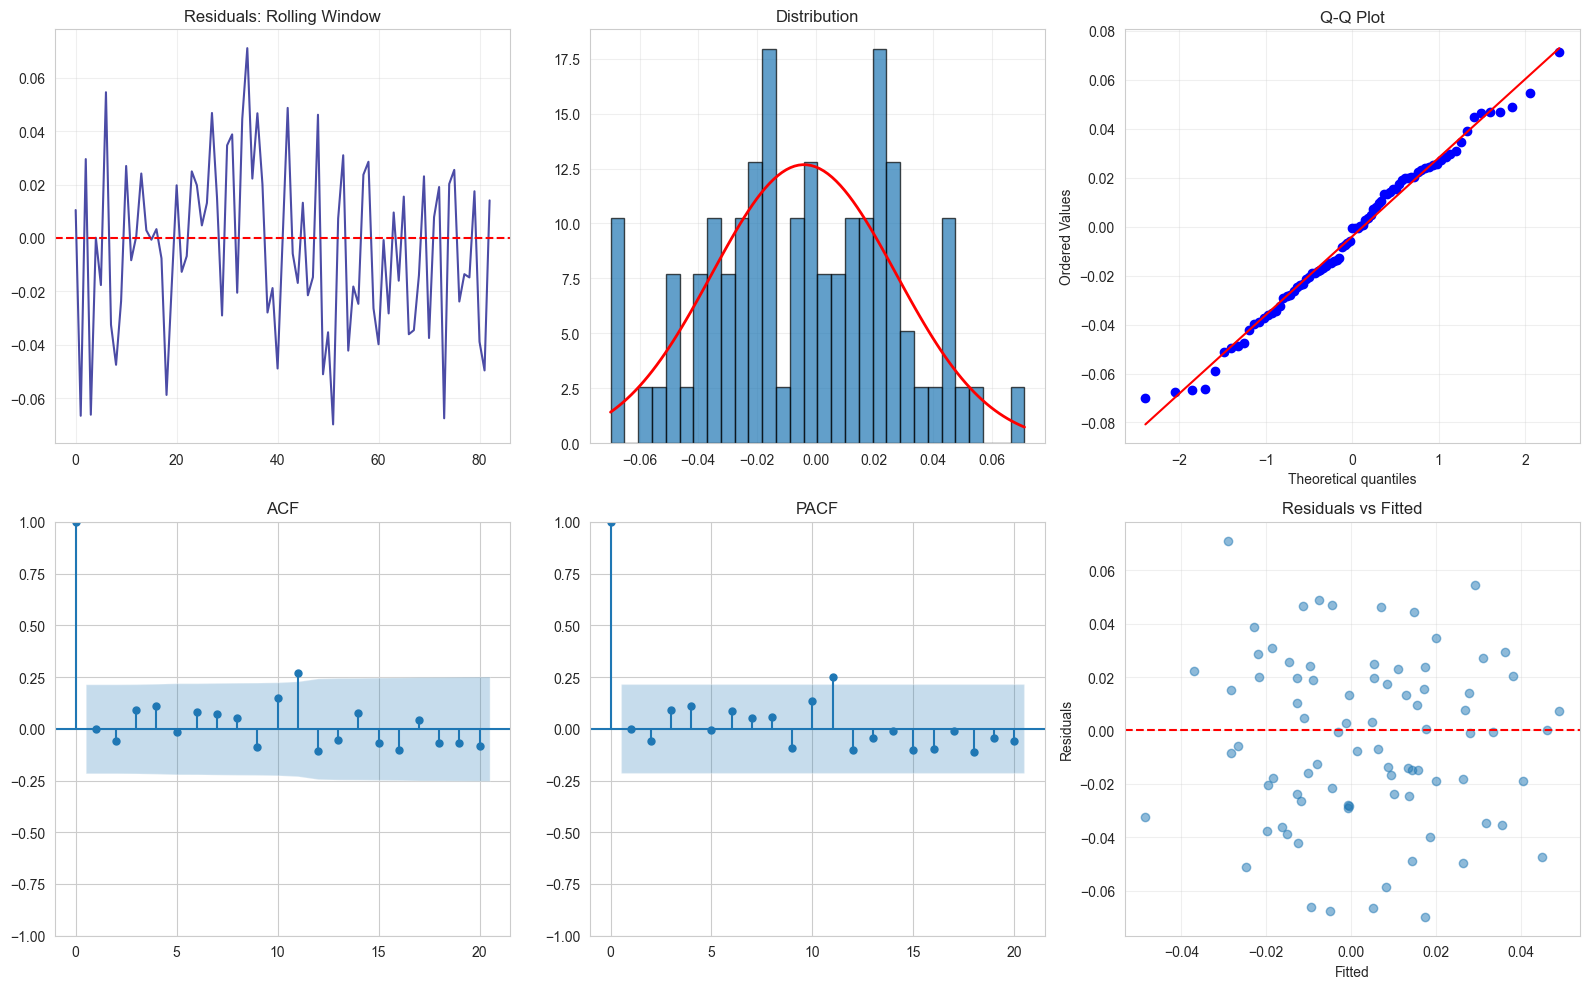

DIAGNOSTICS: Expanding Window

Mean: -0.002972 | Std: 0.031038
Jarque-Bera p-value: 0.5325 ✓ Normal
Ljung-Box p-value: 0.6279 ✓ No autocorr
Durbin-Watson: 1.9381 (2=no autocorr, <2=pos, >2=neg)
Levene's p-value: 0.8152 ✓ Homoskedastic



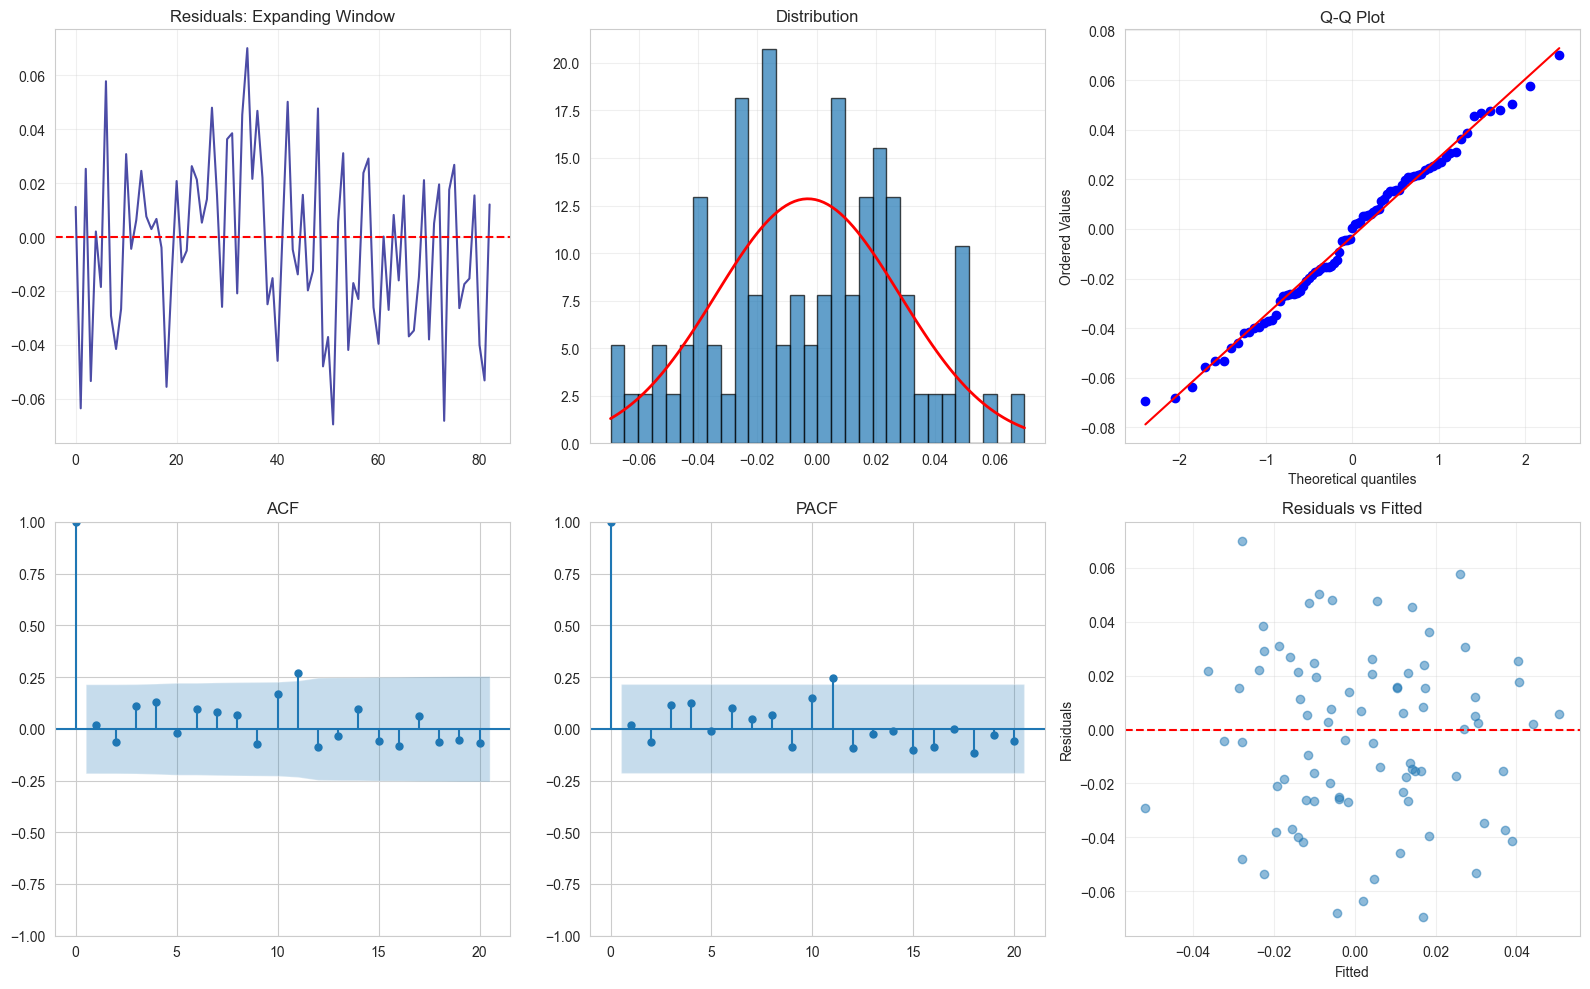

DIAGNOSTICS: One-Step

Mean: -0.003038 | Std: 0.030945
Jarque-Bera p-value: 0.5372 ✓ Normal
Ljung-Box p-value: 0.6164 ✓ No autocorr
Durbin-Watson: 1.9458 (2=no autocorr, <2=pos, >2=neg)
Levene's p-value: 0.8273 ✓ Homoskedastic

AR(3) Coefficients: φ₁=-0.6638, φ₂=-0.3016, φ₃=-0.1807
Stability: ✓ STABLE (roots: [1.8763889  1.8763889  1.57189842])



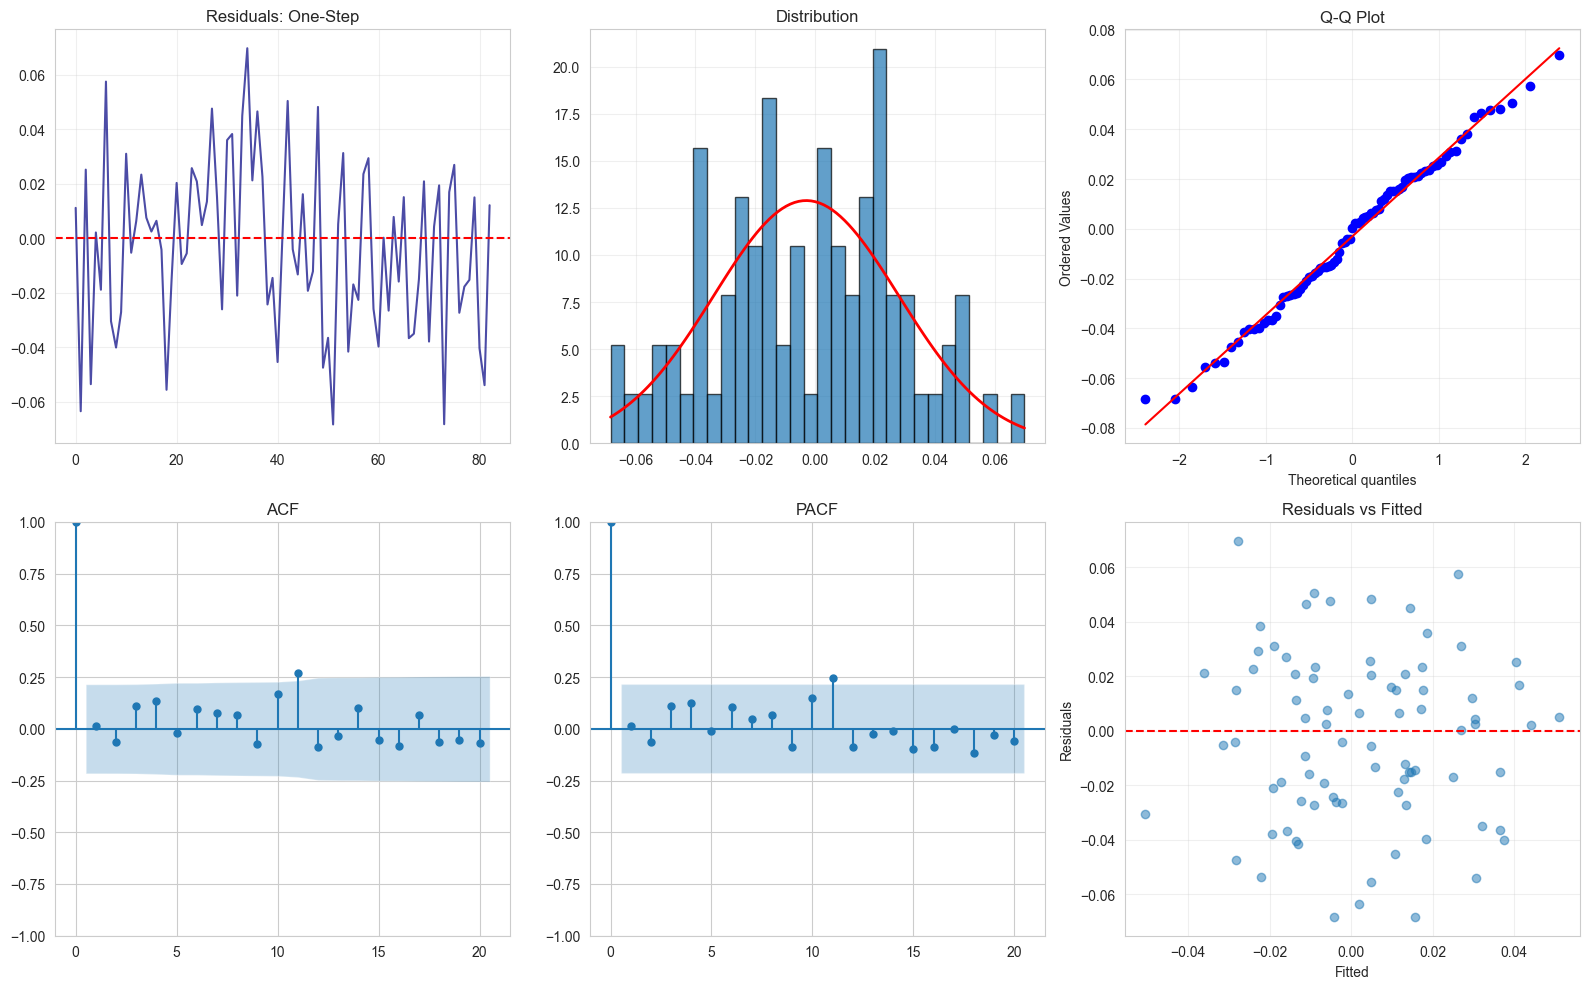


✓ Diagnostics complete! Plots saved.


In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import durbin_watson
import seaborn as sns

sns.set_style("whitegrid")

# =============================================================================
# DIAGNOSTICS FOR AR(3) FORECASTS
# =============================================================================

def run_diagnostics(predictions, actuals, scheme_name, coeffs=None):
    """
    Run diagnostic tests and print results
    """
    residuals = actuals - predictions
    
    print("="*70)
    print(f"DIAGNOSTICS: {scheme_name}")
    print("="*70)
    
    # Basic statistics
    print(f"\nMean: {np.mean(residuals):.6f} | Std: {np.std(residuals):.6f}")
    
    # Normality test
    _, jb_p = stats.jarque_bera(residuals)
    print(f"Jarque-Bera p-value: {jb_p:.4f} {'✓ Normal' if jb_p > 0.05 else '✗ Not normal'}")
    
    # Autocorrelation test
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    lb_p = lb_test.iloc[0]['lb_pvalue']
    print(f"Ljung-Box p-value: {lb_p:.4f} {'✓ No autocorr' if lb_p > 0.05 else '✗ Autocorr detected'}")
    
    # Durbin-Watson
    dw = durbin_watson(residuals)
    print(f"Durbin-Watson: {dw:.4f} (2=no autocorr, <2=pos, >2=neg)")
    
    # Heteroskedasticity
    _, levene_p = stats.levene(residuals[:len(residuals)//2], residuals[len(residuals)//2:])
    print(f"Levene's p-value: {levene_p:.4f} {'✓ Homoskedastic' if levene_p > 0.05 else '✗ Heteroskedastic'}")
    
    # Stability check
    if coeffs is not None:
        poly_coeffs = [coeffs[2], coeffs[1], coeffs[0], -1]
        roots = np.roots(poly_coeffs)
        abs_roots = np.abs(roots)
        stable = all(abs_roots > 1)
        print(f"\nAR(3) Coefficients: φ₁={coeffs[0]:.4f}, φ₂={coeffs[1]:.4f}, φ₃={coeffs[2]:.4f}")
        print(f"Stability: {'✓ STABLE' if stable else '✗ UNSTABLE'} (roots: {abs_roots})")
    
    print("="*70 + "\n")


# Run diagnostics for each scheme
print("\n" + "█"*70)
print("AR(3) FORECAST DIAGNOSTICS")
print("█"*70 + "\n")

# Rolling Window
run_diagnostics(rolling_pred, rolling_actual, "Rolling Window")

fig = plt.figure(figsize=(16, 10))
residuals_rolling = rolling_actual - rolling_pred

# Time series plot
ax1 = plt.subplot(2, 3, 1)
ax1.plot(residuals_rolling, color='navy', alpha=0.7)
ax1.axhline(y=0, color='red', linestyle='--')
ax1.set_title('Residuals: Rolling Window')
ax1.grid(True, alpha=0.3)

# Histogram + Q-Q
ax2 = plt.subplot(2, 3, 2)
ax2.hist(residuals_rolling, bins=30, density=True, alpha=0.7, edgecolor='black')
mu, std = np.mean(residuals_rolling), np.std(residuals_rolling)
x = np.linspace(residuals_rolling.min(), residuals_rolling.max(), 100)
ax2.plot(x, stats.norm.pdf(x, mu, std), 'r-', linewidth=2)
ax2.set_title('Distribution')
ax2.grid(True, alpha=0.3)

ax3 = plt.subplot(2, 3, 3)
stats.probplot(residuals_rolling, dist="norm", plot=ax3)
ax3.set_title('Q-Q Plot')
ax3.grid(True, alpha=0.3)

# ACF/PACF
ax4 = plt.subplot(2, 3, 4)
plot_acf(residuals_rolling, lags=min(30, len(residuals_rolling)//4), ax=ax4, alpha=0.05)
ax4.set_title('ACF')

ax5 = plt.subplot(2, 3, 5)
plot_pacf(residuals_rolling, lags=min(30, len(residuals_rolling)//4), ax=ax5, alpha=0.05, method='ywm')
ax5.set_title('PACF')

# Residuals vs Fitted
ax6 = plt.subplot(2, 3, 6)
ax6.scatter(rolling_pred, residuals_rolling, alpha=0.5)
ax6.axhline(y=0, color='red', linestyle='--')
ax6.set_title('Residuals vs Fitted')
ax6.set_xlabel('Fitted')
ax6.set_ylabel('Residuals')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('diagnostics_rolling.png', dpi=300, bbox_inches='tight')
plt.show()


# Expanding Window
run_diagnostics(expanding_pred, expanding_actual, "Expanding Window")
residuals_expanding = expanding_actual - expanding_pred

fig = plt.figure(figsize=(16, 10))

ax1 = plt.subplot(2, 3, 1)
ax1.plot(residuals_expanding, color='navy', alpha=0.7)
ax1.axhline(y=0, color='red', linestyle='--')
ax1.set_title('Residuals: Expanding Window')
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(2, 3, 2)
ax2.hist(residuals_expanding, bins=30, density=True, alpha=0.7, edgecolor='black')
mu, std = np.mean(residuals_expanding), np.std(residuals_expanding)
x = np.linspace(residuals_expanding.min(), residuals_expanding.max(), 100)
ax2.plot(x, stats.norm.pdf(x, mu, std), 'r-', linewidth=2)
ax2.set_title('Distribution')
ax2.grid(True, alpha=0.3)

ax3 = plt.subplot(2, 3, 3)
stats.probplot(residuals_expanding, dist="norm", plot=ax3)
ax3.set_title('Q-Q Plot')
ax3.grid(True, alpha=0.3)

ax4 = plt.subplot(2, 3, 4)
plot_acf(residuals_expanding, lags=min(30, len(residuals_expanding)//4), ax=ax4, alpha=0.05)
ax4.set_title('ACF')

ax5 = plt.subplot(2, 3, 5)
plot_pacf(residuals_expanding, lags=min(30, len(residuals_expanding)//4), ax=ax5, alpha=0.05, method='ywm')
ax5.set_title('PACF')

ax6 = plt.subplot(2, 3, 6)
ax6.scatter(expanding_pred, residuals_expanding, alpha=0.5)
ax6.axhline(y=0, color='red', linestyle='--')
ax6.set_title('Residuals vs Fitted')
ax6.set_xlabel('Fitted')
ax6.set_ylabel('Residuals')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('diagnostics_expanding.png', dpi=300, bbox_inches='tight')
plt.show()


# One-Step (with stability check)
# Get coefficients for stability analysis
def fit_ar3(y_train):
    def create_ar3_features(y, lag=3):
        n = len(y)
        X = np.zeros((n - lag, lag))
        y_target = np.zeros(n - lag)
        for i in range(lag, n):
            X[i - lag] = [y[i-1], y[i-2], y[i-3]]
            y_target[i - lag] = y[i]
        return X, y_target
    
    X, y_target = create_ar3_features(y_train, lag=3)
    X_with_intercept = np.column_stack([X, np.ones(len(X))])
    coeffs = np.linalg.lstsq(X_with_intercept, y_target, rcond=None)[0]
    return coeffs

y_combined = np.concatenate([y_train, y_test])
coeffs_onestep = fit_ar3(y_combined[:len(y_train)])

run_diagnostics(onestep_pred, onestep_actual, "One-Step", coeffs=coeffs_onestep)
residuals_onestep = onestep_actual - onestep_pred

fig = plt.figure(figsize=(16, 10))

ax1 = plt.subplot(2, 3, 1)
ax1.plot(residuals_onestep, color='navy', alpha=0.7)
ax1.axhline(y=0, color='red', linestyle='--')
ax1.set_title('Residuals: One-Step')
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(2, 3, 2)
ax2.hist(residuals_onestep, bins=30, density=True, alpha=0.7, edgecolor='black')
mu, std = np.mean(residuals_onestep), np.std(residuals_onestep)
x = np.linspace(residuals_onestep.min(), residuals_onestep.max(), 100)
ax2.plot(x, stats.norm.pdf(x, mu, std), 'r-', linewidth=2)
ax2.set_title('Distribution')
ax2.grid(True, alpha=0.3)

ax3 = plt.subplot(2, 3, 3)
stats.probplot(residuals_onestep, dist="norm", plot=ax3)
ax3.set_title('Q-Q Plot')
ax3.grid(True, alpha=0.3)

ax4 = plt.subplot(2, 3, 4)
plot_acf(residuals_onestep, lags=min(30, len(residuals_onestep)//4), ax=ax4, alpha=0.05)
ax4.set_title('ACF')

ax5 = plt.subplot(2, 3, 5)
plot_pacf(residuals_onestep, lags=min(30, len(residuals_onestep)//4), ax=ax5, alpha=0.05, method='ywm')
ax5.set_title('PACF')

ax6 = plt.subplot(2, 3, 6)
ax6.scatter(onestep_pred, residuals_onestep, alpha=0.5)
ax6.axhline(y=0, color='red', linestyle='--')
ax6.set_title('Residuals vs Fitted')
ax6.set_xlabel('Fitted')
ax6.set_ylabel('Residuals')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('diagnostics_onestep.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Diagnostics complete! Plots saved.")

PREDICTIONS TRANSFORMED TO REAL PRICES

Last training price: $130,183.76
First test price: $129,879.89

First predictions (real prices):
  Rolling Window:  $128,526.84
  Expanding Window: $128,437.81
  One-Step:        $128,437.81

METRICS IN REAL PRICE SPACE
   Scheme         RMSE          MAE      MAPE        R²
  Rolling 21328.774166 18218.613449 13.809207 -4.905050
Expanding 16744.258852 14146.806602 10.481479 -2.639349
 One-Step 16724.094245 14170.513215 10.519756 -2.630588


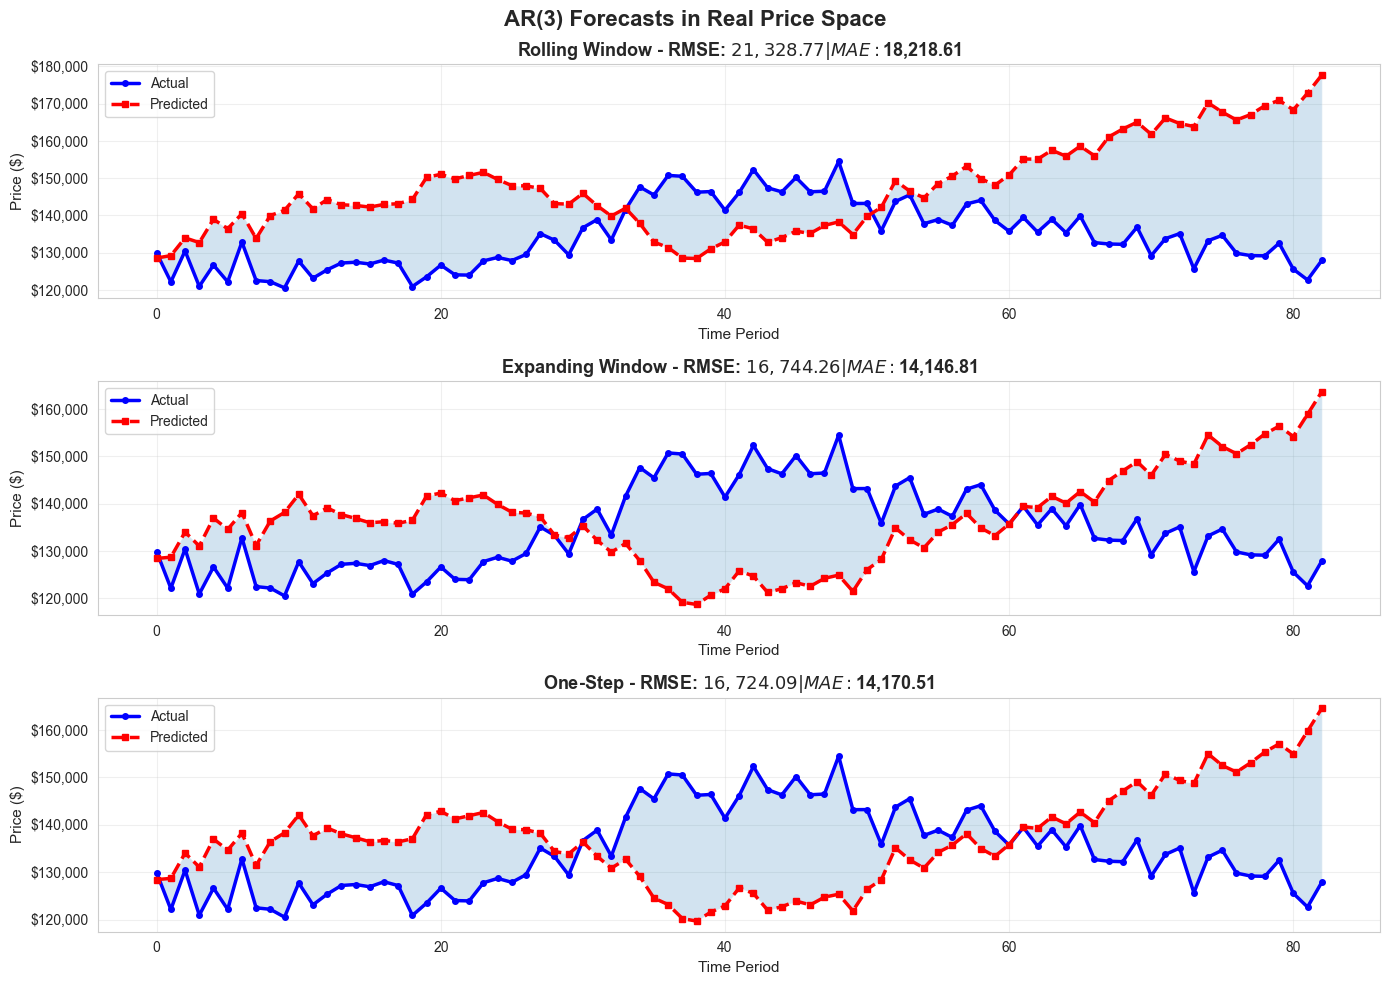

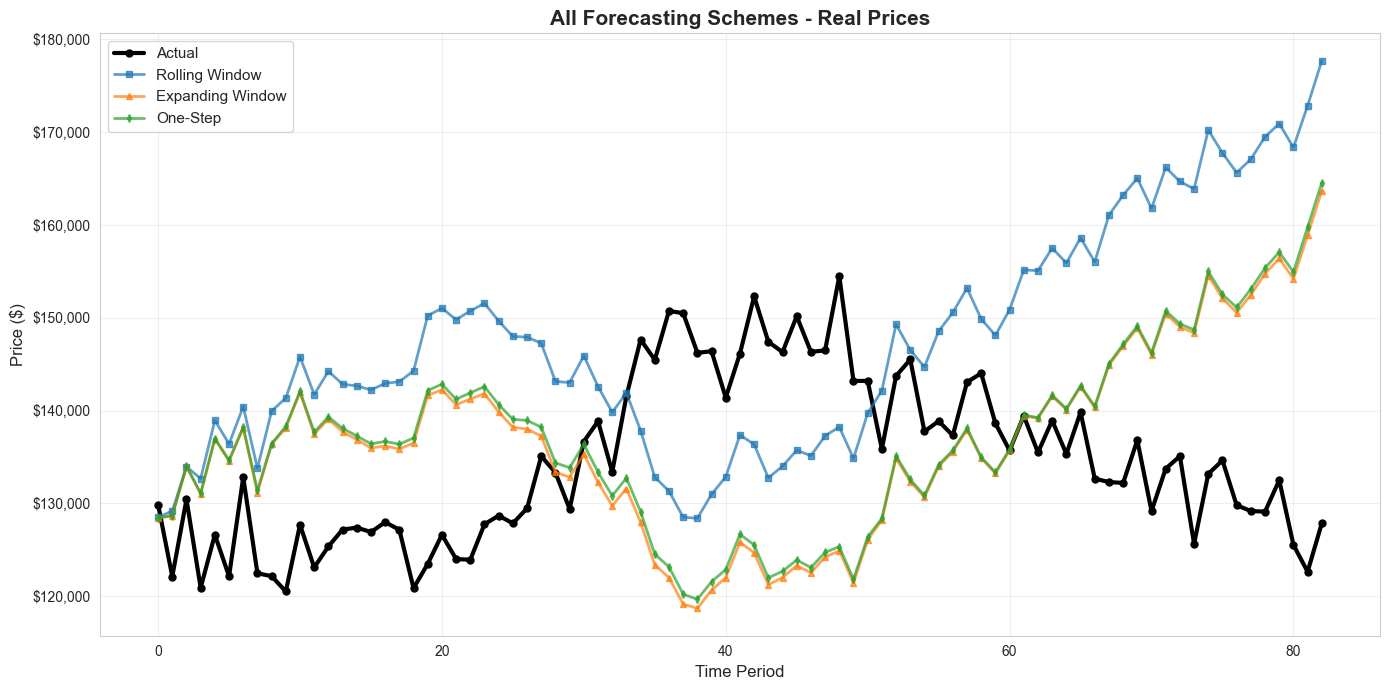


✓ Transformation complete! Plots saved.
  - forecast_real_prices.png
  - forecast_all_schemes_real_prices.png


In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =============================================================================
# INVERSE TRANSFORMATION: Log-Differencing to Real Prices
# =============================================================================

def inverse_log_diff(predictions, last_known_price):
    """
    Transform log-differenced predictions back to real prices
    
    Parameters:
    -----------
    predictions : array-like
        AR(3) predictions in log-differenced space
    last_known_price : float
        The last known actual price before the forecast period
        (this is needed to reconstruct the price level)
    
    Returns:
    --------
    real_prices : array
        Predictions transformed back to real price levels
    
    Note:
    -----
    If you did: log_diff = log(price[t]) - log(price[t-1])
    Then: price[t] = price[t-1] * exp(log_diff[t])
    """
    predictions = np.array(predictions)
    real_prices = np.zeros(len(predictions))
    
    # First prediction
    real_prices[0] = last_known_price * np.exp(predictions[0])
    
    # Subsequent predictions (cumulative)
    for i in range(1, len(predictions)):
        real_prices[i] = real_prices[i-1] * np.exp(predictions[i])
    
    return real_prices


def inverse_transform_all_schemes(rolling_pred, expanding_pred, onestep_pred, 
                                   y_train_original, y_test_original):
    """
    Transform all three forecasting schemes back to real prices
    
    Parameters:
    -----------
    rolling_pred, expanding_pred, onestep_pred : arrays
        Predictions in log-differenced space
    y_train_original : array
        Original training prices (NOT log-differenced)
    y_test_original : array
        Original test prices (NOT log-differenced) for comparison
    
    Returns:
    --------
    Dictionary with transformed predictions and actuals
    """
    # Last known price from training set
    last_known_price = y_train_original[-1]
    
    # Transform predictions
    rolling_real = inverse_log_diff(rolling_pred, last_known_price)
    expanding_real = inverse_log_diff(expanding_pred, last_known_price)
    onestep_real = inverse_log_diff(onestep_pred, last_known_price)
    
    results = {
        'rolling': rolling_real,
        'expanding': expanding_real,
        'onestep': onestep_real,
        'actual': y_test_original
    }
    
    return results


# =============================================================================
# EXAMPLE USAGE
# =============================================================================

# Assuming you have:
# - y_train_original: original prices before log-differencing
# - y_test_original: original test prices
# - rolling_pred, expanding_pred, onestep_pred: predictions in log-diff space

# Transform back to real prices
real_predictions = inverse_transform_all_schemes(
    rolling_pred, 
    expanding_pred, 
    onestep_pred,
    y_train_original,
    y_test_original
)

# Extract results
rolling_real = real_predictions['rolling']
expanding_real = real_predictions['expanding']
onestep_real = real_predictions['onestep']
actual_prices = real_predictions['actual']

print("="*70)
print("PREDICTIONS TRANSFORMED TO REAL PRICES")
print("="*70)
print(f"\nLast training price: ${y_train_original[-1]:,.2f}")
print(f"First test price: ${y_test_original[0]:,.2f}")
print(f"\nFirst predictions (real prices):")
print(f"  Rolling Window:  ${rolling_real[0]:,.2f}")
print(f"  Expanding Window: ${expanding_real[0]:,.2f}")
print(f"  One-Step:        ${onestep_real[0]:,.2f}")
print("="*70)

# Calculate errors in real price space
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_real_price_metrics(pred, actual):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mape = np.mean(np.abs((actual - pred) / actual)) * 100
    r2 = r2_score(actual, pred)
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R²': r2}

# Metrics in real price space
print("\nMETRICS IN REAL PRICE SPACE")
print("="*70)

metrics_rolling = calculate_real_price_metrics(rolling_real, actual_prices)
metrics_expanding = calculate_real_price_metrics(expanding_real, actual_prices)
metrics_onestep = calculate_real_price_metrics(onestep_real, actual_prices)

results_df = pd.DataFrame([
    {'Scheme': 'Rolling', **metrics_rolling},
    {'Scheme': 'Expanding', **metrics_expanding},
    {'Scheme': 'One-Step', **metrics_onestep}
])

print(results_df.to_string(index=False))
print("="*70)

# =============================================================================
# VISUALIZATION: Real Prices
# =============================================================================

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

schemes_real = [
    ('Rolling Window', rolling_real),
    ('Expanding Window', expanding_real),
    ('One-Step', onestep_real)
]

for idx, (name, pred) in enumerate(schemes_real):
    ax = axes[idx]
    time_index = range(len(pred))
    
    ax.plot(time_index, actual_prices, label='Actual', 
            color='blue', linewidth=2.5, marker='o', markersize=4)
    ax.plot(time_index, pred, label='Predicted', 
            color='red', linestyle='--', linewidth=2.5, marker='s', markersize=4)
    ax.fill_between(time_index, actual_prices, pred, alpha=0.2)
    
    rmse = np.sqrt(mean_squared_error(actual_prices, pred))
    mae = mean_absolute_error(actual_prices, pred)
    
    ax.set_title(f'{name} - RMSE: ${rmse:,.2f} | MAE: ${mae:,.2f}', 
                 fontsize=13, fontweight='bold')
    ax.set_xlabel('Time Period', fontsize=11)
    ax.set_ylabel('Price ($)', fontsize=11)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.suptitle('AR(3) Forecasts in Real Price Space', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('forecast_real_prices.png', dpi=300, bbox_inches='tight')
plt.show()

# Comparison plot
fig, ax = plt.subplots(figsize=(14, 7))

time_index = range(len(actual_prices))
ax.plot(time_index, actual_prices, label='Actual', 
        color='black', linewidth=3, marker='o', markersize=5)
ax.plot(time_index, rolling_real, label='Rolling Window', 
        alpha=0.7, linewidth=2, marker='s', markersize=4)
ax.plot(time_index, expanding_real, label='Expanding Window', 
        alpha=0.7, linewidth=2, marker='^', markersize=4)
ax.plot(time_index, onestep_real, label='One-Step', 
        alpha=0.7, linewidth=2, marker='d', markersize=4)

ax.set_title('All Forecasting Schemes - Real Prices', fontsize=15, fontweight='bold')
ax.set_xlabel('Time Period', fontsize=12)
ax.set_ylabel('Price ($)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.savefig('forecast_all_schemes_real_prices.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Transformation complete! Plots saved.")
print("  - forecast_real_prices.png")
print("  - forecast_all_schemes_real_prices.png")